### Configuration

In [1]:
import os
import numpy as np
import pandas as pd

import mne
import yasa
from yasa import sw_detect

from utils__helpers_macro import robust_zscore
import utils__config

In [2]:
os.chdir(utils__config.working_directory)
os.getcwd()

'Z:\\Layton\\Sleep_083023'

### Parameters

In [3]:
fif_path = 'Cache/Subject05/Jul13/S05_Jul13_micro_1024hz.fif'
hypnogram_path = 'Cache/Subject05/Jul13/S05_Jul13_potatogram.csv'
sum_output_path = 'Cache/Subject05/Jul13/S05_Jul13_micro_SW_summary.csv'
sw_output_path = 'Cache/Subject05/Jul13/S05_Jul13_micro_SW.csv'
sampling_freq = 1024
n_jobs = -2

### Spike Interpolation (not implemented)

### Upsample Hypnogram

In [4]:
raw = mne.io.read_raw_fif(fif_path, preload = True, verbose = False)
hypno_256 = np.genfromtxt(hypnogram_path, delimiter=',', skip_header=0)

C:\Users\lal85\AppData\Local\Temp\2\ipykernel_22304\29791937.py:1: RuntimeWarning: This filename (Cache/Subject05/Jul13/S05_Jul13_micro_1024hz.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_path, preload = True, verbose = False)


In [5]:
hypno_1024 = yasa.hypno_upsample_to_data(hypno = hypno_256,
                                         sf_hypno = 256,
                                         data = raw)

28-Nov-23 15:46:32 | WARNING | Hypnogram is LONGER than data by 14976.00 seconds. Cropping hypnogram to match data.size.


### Detect Slow-Waves

In [6]:
# Convert V to uV for YASA
data = raw.get_data() * 1e6

# Normalize using robust z-score
rz_data = np.apply_along_axis(func1d = robust_zscore, axis = 0, arr = data)

In [7]:
# SleepTrip equivalent parameters (for comparison): 
# Bandpass:                         0.2 - 4 Hz (Subject01), 0.5 - 4 Hz (Subject02)
# Duration of entire SW:            0.5 - 3.3 seconds
# Minimum of positive peak:         25 uV
# Maximum of negative peak:         -50 uV (Subject01), -100 uV (Subject02)
# Peak-to-trough amplitude:         200 - 5000 uV
# Outlier removal:                  100 standard deviations

# If not passing an MNE raw object, you will need to convert 
# values from V to uV and specify sf (sampling_freq) and ch_names
sw = sw_detect(rz_data,
               sf = sampling_freq,
               ch_names = raw.ch_names,
               hypno = hypno_1024, # optionally load a hypnogram file
               include = (2, 3), # only include SW's detected in N2 and N3 sleep (if hypnogram is specified)
               freq_sw = (0.3, 1.5), # bandpass to look at SW's (Hz); default (0.3, 1.5)
               dur_neg = (0.3, 1.5), # min/max duration of negative deflection (seconds); default (0.3, 1.5)
               dur_pos = (0.1, 1.5), # min/max duration of positive reflection (seconds); default (0.1, 1.0)
               amp_neg = (1.0, None), # min/max peak amplitude of negative deflection (uV); can be (None, None); default (40, 200)
               amp_pos = (1.0, None), # min/max peak amplitude of positive reflection (uV); can be (None, None); default (10, 150)
               amp_ptp = (4.0, np.inf), # min/max peak-to-peak amplitude (uV); upper limit can be set as np.inf; default (75, 350)
               coupling = False, # irrelevant to us (see documentation)
               remove_outliers = True, # automatically remove outliers using sklearn's Isolation Forest
               verbose = False)

slow_waves = sw.summary()
slow_waves['ID'] = slow_waves.index + 1

# Save to CSV and print summary/plot
sw.summary(grp_stage = True)
#sw.plot_average(center = 'NegPeak', time_before = 1, time_after = 1)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    6.3s
28-Nov-23 16:22:43 | WARNING | No SW were found in channel Channel193.
28-Nov-23 16:22:44 | WARNING | No SW were found in channel Channel194.
28-Nov-23 16:22:44 | WARNING | No SW were found in channel Channel195.
28-Nov-23 16:22:45 | WARNING | No SW were found in channel Channel196.
28-Nov-23 16:22:45 | WARNING | No SW were found in channel Channel197.
28-Nov-23 16:22:46 | WARNING | No SW were found in channel Channel198.
28-Nov-23 16:22:50 | WARNING | No SW were found in channel Channel208.


,Count,Density,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency
Stage,,,,,,,,
2,92825,463.391259,1.044072,-4.191012,3.765000,7.956013,35.730081,1.024962
3,6613,415.476440,1.111450,-3.481226,3.280056,6.761282,29.350232,0.966584


In [8]:
sw.compare_channels()

Channel,Channel199,Channel200,Channel201,Channel202,Channel203,Channel204,Channel205,Channel206,Channel207,Channel209,...,Channel247,Channel248,Channel249,Channel250,Channel251,Channel252,Channel253,Channel254,Channel255,Channel256
Channel,,,,,,,,,,,,,,,,,,,,,
Channel199,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000302,0.000303,0.000000,0.000297,0.000298,0.000303,0.000304,0.000000
Channel200,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000303,0.000000,0.000297,0.000298,0.000000,0.000000,0.000304
Channel201,0.000000,0.000000,1.000000,0.007921,0.398352,0.003976,0.237952,0.182421,0.288571,0.003774,...,0.001299,0.002060,0.002819,0.004249,0.002847,0.005279,0.003067,0.003675,0.002840,0.002552
Channel202,0.000000,0.000000,0.007921,1.000000,0.047138,0.166667,0.085837,0.081395,0.022305,0.040404,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Channel203,0.000000,0.000000,0.398352,0.047138,1.000000,0.040678,0.587719,0.450633,0.357724,0.018634,...,0.001393,0.002177,0.002614,0.003794,0.002054,0.003147,0.002010,0.002039,0.002049,0.002922
Channel204,0.000000,0.000000,0.003976,0.166667,0.040678,1.000000,0.086580,0.141176,0.052434,0.020619,...,0.000000,0.000000,0.000000,0.000000,0.000303,0.000000,0.000000,0.000000,0.000000,0.000000
Channel205,0.000000,0.000000,0.237952,0.085837,0.587719,0.086580,1.000000,0.531722,0.317757,0.023256,...,0.000713,0.000554,0.001759,0.002062,0.001481,0.002599,0.001449,0.001764,0.001477,0.001475
Channel206,0.000000,0.000000,0.182421,0.081395,0.450633,0.141176,0.531722,1.000000,0.403270,0.030457,...,0.000728,0.000563,0.001479,0.001189,0.001495,0.001165,0.001169,0.001187,0.001491,0.001191
Channel207,0.000000,0.000000,0.288571,0.022305,0.357724,0.052434,0.317757,0.403270,1.000000,0.013605,...,0.000703,0.002194,0.002333,0.002930,0.002652,0.003447,0.002594,0.002047,0.002057,0.001761


interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(align_items='center', justify_con…

<function yasa.detection._DetectionResults.plot_detection.<locals>.update(epoch, amplitude, channel, win_size, filt)>

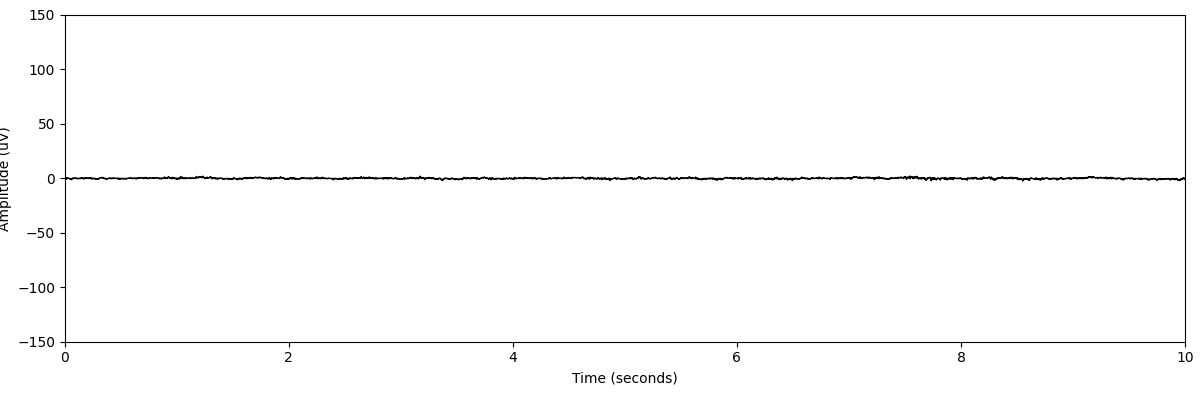

In [9]:
%matplotlib widget
sw.plot_detection()

### Export

In [10]:
# Extract event counts by channel
sw_sum = sw.summary(grp_chan = True, grp_stage = False, aggfunc = 'median').reset_index()
sw_sum = sw_sum[['Channel', 'Count']]
sw_sum.columns = ['channel', 'sw']
sw_sum.to_csv(sum_output_path, index = False)

# Save to CSV
slow_waves.to_csv(sw_output_path, index = False)